In [13]:
import osmnx as ox
import igraph as ig
import pandas as pd
import networkx as nx
import numpy as np
import multiprocessing as mp
import time
import random as rd
from itertools import product
import ast
from numpy import inf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy
import math

# Alpha Data:

In [2]:
def bin_calculator(city_name, sample_method):
    
    data = pd.read_csv('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Shuffle_data/'+city_name+'_teste/'+city_name+'_FULL_fractions_L_data_shuffle.dat',
                      index_col=0)
    fractions = list(data['One way Fraction'])
    l_lengths = list(data['L from length'])
    
    if sample_method:
        
        sample_index = np.random.choice(len(l_lengths), 100000, replace=True)

        sample_fractions = [fractions[i] for i in sample_index]
        sample_L_from = [l_lengths[i] for i in sample_index]

        minimo=100
        maximo = max(sample_L_from)
        n_bins=15
        bins=(np.e)**np.linspace(np.log(minimo),np.log(maximo),n_bins)
        
        frac_bin = []
        
        for b in range(n_bins-1):
            new_bin = []
            for j in range(len(sample_L_from)):
                if sample_L_from[j]>bins[b] and sample_L_from[j]<bins[b+1]:
                    new_bin.append(sample_fractions[j])
            frac_bin.append(new_bin)
            
        mean_per_bin = [np.mean(lista) for lista in frac_bin]
        std_per_bin = [np.std(lista) for lista in frac_bin]
        
    else:
        minimo=100
        maximo = max(l_lengths)
        n_bins=15
        bins=(np.e)**np.linspace(np.log(minimo),np.log(maximo),n_bins)
        
        frac_bin = []
        
        for b in range(n_bins-1):
            new_bin = []
            for j in range(len(l_lengths)):
                if l_lengths[j]>bins[b] and l_lengths[j]<bins[b+1]:
                    new_bin.append(fractions[j])
            frac_bin.append(new_bin)
            
        mean_per_bin = [np.mean(lista) for lista in frac_bin]
        std_per_bin = [np.std(lista) for lista in frac_bin]
    
    return mean_per_bin, std_per_bin, bins

In [3]:
def alpha_sampler(city_name, sample_mode, number):

    mean_list = []
    bins_list = []

    for k in range(number):
        print(k)

        mean_frac, std_frac_bins, bins = bin_calculator(city_name, sample_mode)

        mean_list.append(mean_frac)
        bins_list.append(bins)
        clear_output(True)
        
    return mean_list, bins_list

# Slope calculation:

In [4]:
def alpha_calculator(bins, mean_list, left_lim, right_lim):
        
    x = 0.5*(bins[:-1]+bins[1:])
    log_x = np.array([np.log(v) for v in x])
    
    y = [y for y in mean_list]
    log_y = np.array([np.log(w) for w in y])
        
    log_y = log_y[log_x>np.log(left_lim)]
    log_x = log_x[log_x>np.log(left_lim)]
    
    log_y = log_y[log_x<np.log(right_lim)]
    log_x = log_x[log_x<np.log(right_lim)]
    
    indices = [i for i in range(len(log_y)) if math.isinf(log_y[i])==False and math.isnan(log_y[i])==False]
    
    log_y = [log_y[j] for j in indices]
    log_x = [log_x[k] for k in indices]
    
    results = scipy.stats.linregress(log_x, log_y)
        
    return results

In [5]:
def alphas_calc(bins_list, mean_list, left_lim, right_lim, number):
    
    alphas = []
    lin_err = []
    inter = []
    
    for i in range(number):
        
        res = alpha_calculator(bins_list[i], mean_list[i],
                              left_lim, right_lim)
        
        alphas.append(res.slope)
        lin_err.append(res.stderr)
        inter.append(res.intercept)


    
    indices = [j for j in range(len(alphas)) if np.isnan(alphas[j])==False]
    
    alphas_clean = [alphas[j] for j in indices]
    lin_errors_clean = [lin_err[k] for k in indices]
    inter_clean = [inter[p] for p in indices]
    
    return np.mean(alphas_clean), np.mean(lin_errors_clean), np.mean(inter_clean), np.std(inter_clean)

In [6]:
cities = ['Amsterdam', 'Berlin','Boston', 'Fortaleza', 'Lisbon','Madrid','Manhattan', 'Paris', 'Rome', 'San_Francisco']

In [7]:
frac_sample_data = {}

for city in cities:
    
    mean_frac, bins_frac = alpha_sampler(city, True, 100)
    
    frac_sample_data[city] = {'mean_frac_list':mean_frac, 'bins_frac': bins_frac}

99


In [8]:
frac_data = {}

for city in cities:
    
    mean_frac, std_per_bin, bins_frac = bin_calculator(city, False)
    
    frac_data[city] = {'mean_frac_list':mean_frac, 'bins_frac': bins_frac}

In [9]:
np.save('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Frac_shuffle_data_dictionary.npy', frac_data) 

In [10]:
import itertools
right_lim = np.linspace(10**4, 10**4.5, 5)
left_lim = [v for v in range(100, 1000, 25)]

dist_comb = list(itertools.product(left_lim, right_lim))

In [14]:
alpha_data = {}


for city in frac_sample_data.keys():

    alpha_val_list = []
    alpha_error_list = []
    alpha_intercept_list = []
    alpha_intercept_error_list = []
    
    for value in dist_comb:
        
        left = value[0]
        right = value[1]
        
        
        alpha_val,alpha_error,alpha_inter,alpha_inter_err = alphas_calc(frac_sample_data[city]['bins_frac'], 
                                                                        frac_sample_data[city]['mean_frac_list'], 
                                                                        left, right, 100)
        
        alpha_val_list.append(alpha_val)
        alpha_error_list.append(alpha_error)
        alpha_intercept_list.append(alpha_inter)
        alpha_intercept_error_list.append(alpha_inter_err)
            
    alpha_data[city] = {'min_left':dist_comb[alpha_error_list.index(min(alpha_error_list))][0],
                      'min_right':dist_comb[alpha_error_list.index(min(alpha_error_list))][1], 
                       'best_alpha':alpha_val_list[alpha_error_list.index(min(alpha_error_list))], 
                       'best_intercept':alpha_intercept_list[alpha_error_list.index(min(alpha_error_list))], 
                       'alpha_error':alpha_error_list[alpha_error_list.index(min(alpha_error_list))], 
                       'intercept_error':alpha_intercept_error_list[alpha_error_list.index(min(alpha_error_list))],
                       'alpha_val_list':alpha_val_list, 'alpha_error_list':alpha_error_list, 
                      'alpha_intercept_list':alpha_intercept_list, 
                       'alpha_intercept_error':alpha_intercept_error_list}

<ipython-input-4-b2cd3cfb009e>:7: RuntimeWarning: divide by zero encountered in log
  log_y = np.array([np.log(w) for w in y])


In [15]:
np.save('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Alphas_shuffle_dictionary.npy', alpha_data) 

In [16]:
#for city in alpha_data.keys():
 #   print(alpha_data[city]['min_dist'])

In [17]:
alpha_cities = [alpha_data[city]['best_alpha'] for city in alpha_data.keys()]


std_cities = [alpha_data[city]['alpha_error'] for city in alpha_data.keys()]

In [18]:
df = pd.DataFrame(zip(alpha_cities, std_cities), columns = ['alpha', 'std'], index = ['Amsterdam', 'Berlin','Boston', 'Fortaleza', 'Lisbon','Madrid','Manhattan', 'Paris', 'Rome', 'San_Francisco'])

In [23]:
df

,alpha,std
Amsterdam,-0.009057,0.007495
Berlin,-0.004790,0.007697
Boston,0.003529,0.004219
Fortaleza,0.009680,0.005162
Lisbon,0.012886,0.004134
Madrid,-0.002718,0.002919
Manhattan,-0.004440,0.001177
Paris,0.001520,0.001526
Rome,0.010773,0.005842
San_Francisco,-0.003214,0.005043


In [20]:
df.to_csv('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Average_alphas_shuffle_distance_method_final.dat')

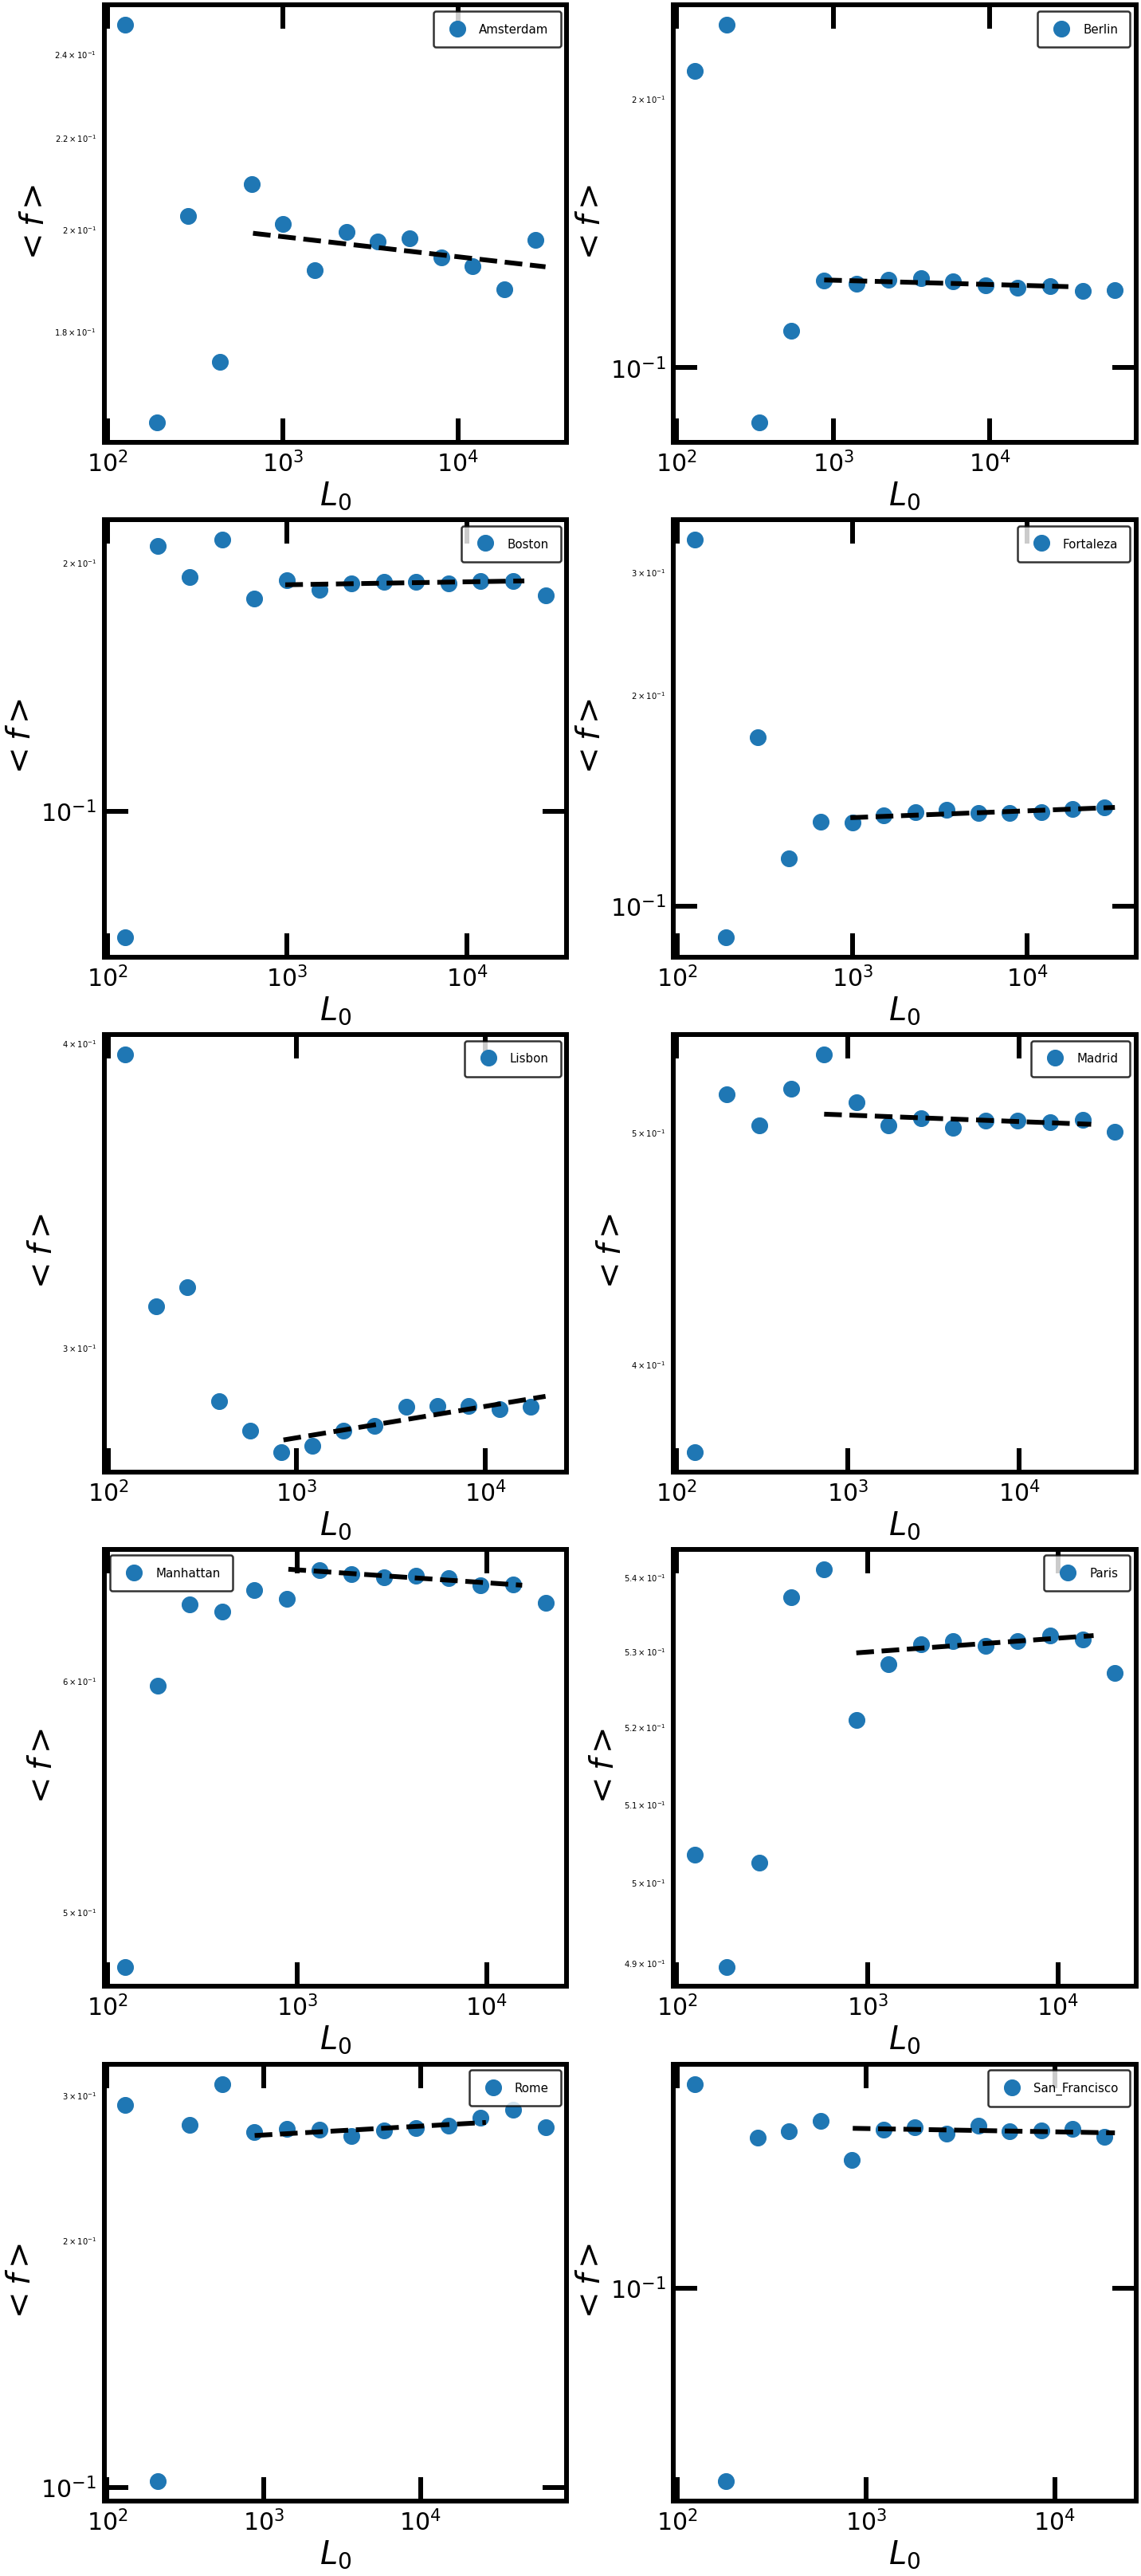

In [22]:
fig, axs = plt.subplots(5,2, figsize=(20,45))
s = 100
axs = axs.ravel()
for city in cities:
    
    i=cities.index(city)
    
    axs[i].plot((0.5*(frac_data[city]['bins_frac'][:-1]+frac_data[city]['bins_frac'][1:])), 
                frac_data[city]['mean_frac_list'], 'o', markersize=20, label=city)
    
    xx = 10**(np.linspace(np.log10(alpha_data[city]['min_left']), 
                          np.log10(alpha_data[city]['min_right']), 10))
        #print(xx)
    yy = (np.exp(alpha_data[city]['best_intercept']))*(xx)**alpha_data[city]['best_alpha']
    axs[i].plot(xx, yy, '--', color='black', linewidth=6)


    for axis in ['top','bottom','left','right']:
        axs[i].spines[axis].set_linewidth(6)

    axs[i].set_xlabel('$L_{0}$', fontsize=40)
    axs[i].xaxis.set_ticks_position('both')
    axs[i].set_ylabel('$<f>$', fontsize=40)
    axs[i].yaxis.set_ticks_position('both')
    axs[i].tick_params(which='both', length=30, width=6, direction="in", pad=10)
    axs[i].tick_params(which='minor', length=0)


    axs[i].tick_params(labelsize=30)
    legend = axs[i].legend(borderpad=1, labelspacing=2, fontsize=15, loc='best')
    legend.get_frame().set_linewidth(2.5)
    legend.get_frame().set_edgecolor('black')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Alphas_fits_final.png',  facecolor='white')